# Обучение моделей

## Работа с данными, которые доставлись с главы "Data analysis"

Подключаем библиотеки

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

Читаем ранее сохраненные данные

In [2]:
df = pd.read_csv('Data/newCarDetails.csv')

In [3]:
df.head()

,Unnamed: 0,year,selling_price,km_driven,fuel,seller_type,transmission,owner,brand
0,0,2007,60000,70000,1,0,0,0,0
1,1,2007,135000,50000,1,0,0,0,0
2,2,2012,600000,100000,0,0,0,0,1
3,3,2017,250000,46000,1,0,0,0,13
4,4,2014,450000,141000,0,0,0,1,4


Удаляем лишнюю колонку

In [4]:
df = df.drop(columns=["Unnamed: 0"])

df.shape

(4209, 8)

In [5]:
from sklearn.model_selection import train_test_split

y = df["selling_price"]
X = df.drop(columns=["selling_price"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
y_train.head()

370      800000
3392     150000
2208     235000
3942    1050000
1105     150000
Name: selling_price, dtype: int64

Посмотрим какие значения принимает целевой признак

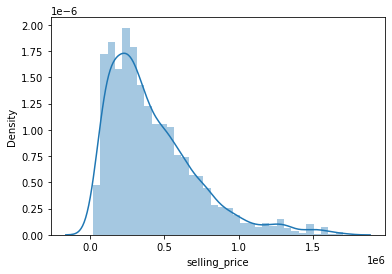

In [7]:
sns.distplot(y_train);

Посмотрим какая есть корреляция между признаками.

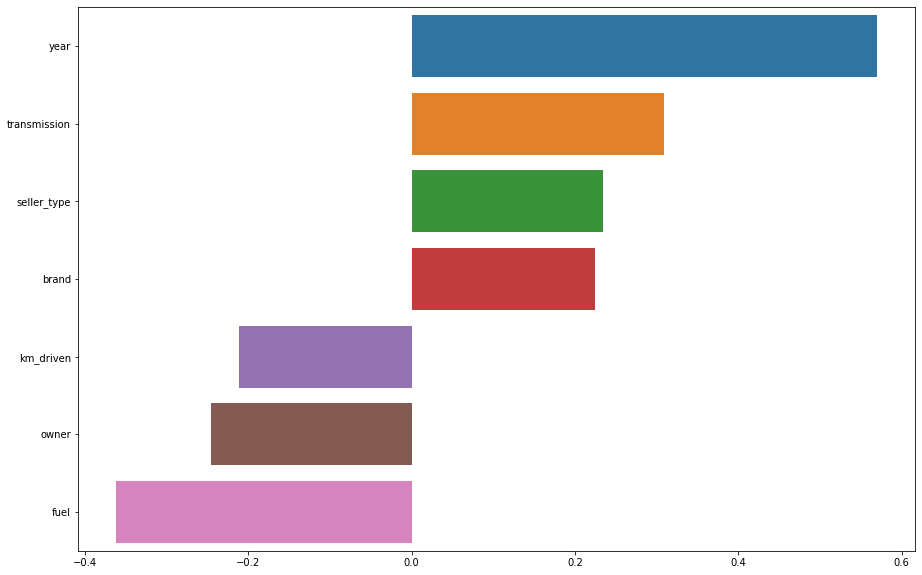

In [8]:
numeric_features = X_train.columns

correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)

plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

Зависимость между признаками умеренная

In [9]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

model = Ridge()  # выбранная модель

model.fit(X_train[numeric_features], y_train)  # обучение модели на обучающей выборке

y_train_pred = model.predict(X_train[numeric_features])  # использование модели для предсказания на обучающей
y_test_pred = model.predict(X_test[numeric_features])  # или на тестовой выборке

print("Test RMSE =", mean_squared_error(y_test, y_test_pred, squared=False))
print("Train RMSE =", mean_squared_error(y_train, y_train_pred, squared=False))
print("Train R2 = %.4f" % r2_score(y_train, y_train_pred))
print("Test R2 = %.4f" % r2_score(y_test, y_test_pred))

Test RMSE = 214346.34752152069
Train RMSE = 212398.819859558
Train R2 = 0.5019
Test R2 = 0.5136


Посмотрим на модель с глупым предсказателем. 

In [10]:
stupid_pred = y_train.mean()
print("Test RMSE with stupid predictor =", mean_squared_error(y_test, stupid_pred * np.ones(y_test.shape),
                                                                 squared=False))
print("Train RMSE with stupid predictor =", mean_squared_error(y_train, stupid_pred * np.ones(y_train.shape),
                                                                  squared=False))

Test RMSE with stupid predictor = 307775.76456505095
Train RMSE with stupid predictor = 300953.91985667974


Далее, анализируя веса, можно понять какие зависимости нашла модель.

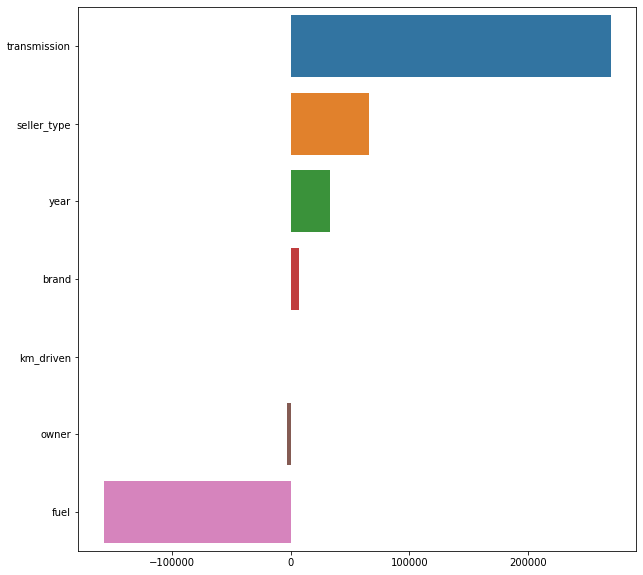

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))

sorted_weights = sorted(zip(model.coef_, numeric_features, X_train[numeric_features].std()), reverse=True)
weights = [x[0] for x in sorted_weights]
features = [x[1] for x in sorted_weights]
sns.barplot(y=features, x=weights, ax=ax)
plt.show()

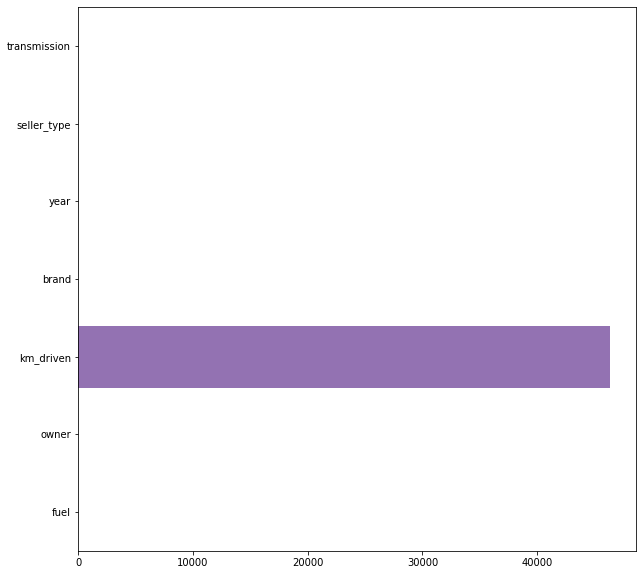

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
scales = [x[2] for x in sorted_weights]
sns.barplot(y=features, x=scales, ax=ax)
plt.show()

Поэтому надо масштабировать признаки перед обучением модели. Для этого воспользуемся трансформером StandardScaler.

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  # воспользуемся стандартным трансформером

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_scaled = scaler.fit_transform(X_train[numeric_features])

# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_scaled = scaler.transform(X_test[numeric_features])

model = Ridge()
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))
print("Train R2 = %.4f" % r2_score(y_train, y_train_pred))
print("Test R2 = %.4f" % r2_score(y_test, y_test_pred))

Test RMSE = 214337.8629
Train RMSE = 212398.4910
Train R2 = 0.5019
Test R2 = 0.5137


Теперь обучение и оценка важности признаков, а также регуляризация стали честнее.

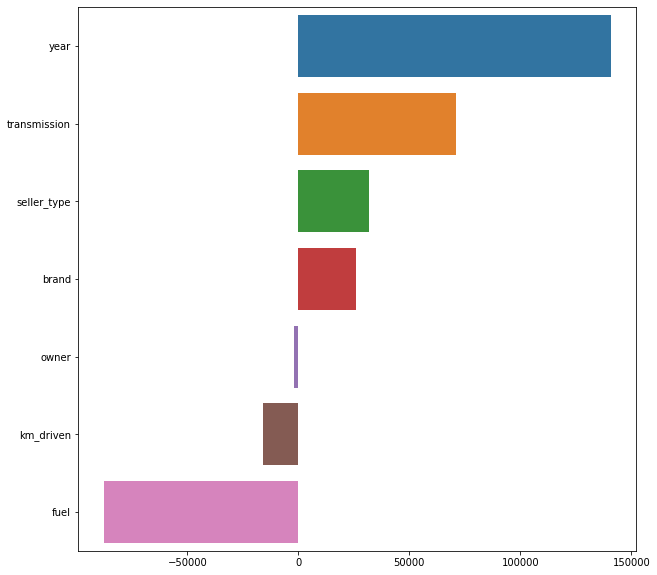

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

sorted_weights = sorted(zip(model.coef_, numeric_features, X_train_scaled.std(axis=0)), reverse=True)
weights = [x[0] for x in sorted_weights]
features = [x[1] for x in sorted_weights]
sns.barplot(y=features, x=weights, ax=ax)
plt.show()

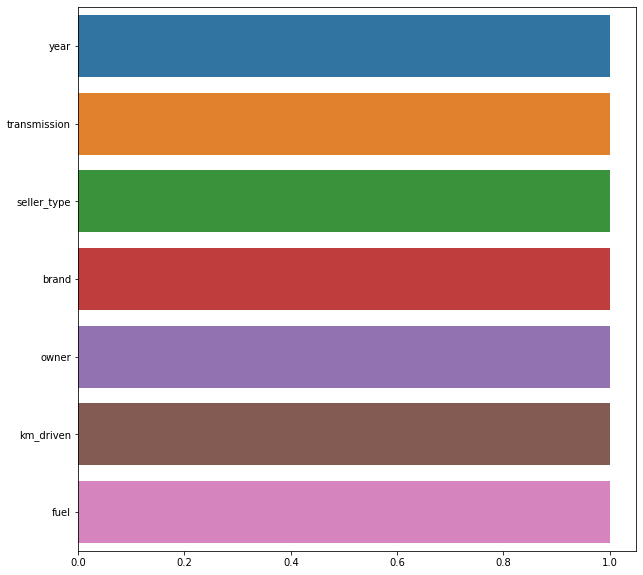

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
scales = [x[2] for x in sorted_weights]
sns.barplot(y=features, x=scales, ax=ax)
plt.show()

## Обучение модели с использованием собственного градиентного спуска

In [22]:
def gradient_descent(x, y, alfa, iters, learning_rate, theta):
    shift = 0
    
    for i in range(iters):
        tmp_y = np.dot(x, theta) + shift
        tmp_theta = (1 / x.shape[0]) * (alfa * np.dot(x.T, (tmp_y - y)))
        tmp_shift = (1 / x.shape[0]) * (alfa * np.sum(tmp_y - y))

        theta = theta - learning_rate * tmp_theta
        shift = shift - learning_rate * tmp_shift

    return theta, shift

Задаем параметры

In [23]:
iters = 5000
alfa = 0.1
learning_rate = 0.1
theta = np.zeros(X_train_scaled.shape[1])

In [24]:
theta_final, gd_shift = gradient_descent(X_train_scaled, y_train, alfa, iters, learning_rate, theta)
y_test_pred = np.dot(X_test_scaled, theta_final) + gd_shift
y_train_pred = np.dot(X_train_scaled, theta_final) + gd_shift

# делаем, чтобы значения rmse и mse были более читабельными
y_test_new = y_test / 100000
y_train_new = y_train / 100000
y_test_pred = y_test_pred / 100000
y_train_pred = y_train_pred / 100000

gd_test_rmse = mean_squared_error(y_test_new, y_test_pred, squared=False)
gd_train_rmse = mean_squared_error(y_train_new, y_train_pred, squared=False)

gd_test_mse = mean_squared_error(y_test_new, y_test_pred, squared=True)
gd_train_mse = mean_squared_error(y_train_new, y_train_pred, squared=True)

gd_test_r2 = r2_score(y_test_new, y_test_pred)
gd_train_r2 = r2_score(y_train_new, y_train_pred)
print(gd_test_r2)

0.513694997555207


## Обучение модели, используя библиотеку Ridge

Ищем оптимальное alpha для Ridge

In [25]:
from sklearn.linear_model import RidgeCV
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

regr_cv = RidgeCV(alphas=[0.1, 1.0, 10.0, 11.0, 15.0, 17.0, 17.001, 17.1, 17.2])
model_cv = regr_cv.fit(X_train_scaled, y_train)
model_cv.alpha_

17.0

In [26]:
alpha = 17.0

ridge_regression = Ridge(alpha=alpha)
ridge_regression.fit(X_train_scaled, y_train)
y_test_pred = ridge_regression.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

y_test_new = y_test / 100000
y_train_new = y_train / 100000
y_test_pred = y_test_pred / 100000
y_train_pred = y_train_pred / 100000

ridge_test_rmse = mean_squared_error(y_test_new, y_test_pred, squared=False)
ridge_train_rmse = mean_squared_error(y_train_new, y_train_pred, squared=False)

ridge_test_mse = mean_squared_error(y_test_new, y_test_pred, squared=True)
ridge_train_mse = mean_squared_error(y_train_new, y_train_pred, squared=True)

ridge_test_r2 = r2_score(y_test_new, y_test_pred)
ridge_train_r2 = r2_score(y_train_new, y_train_pred)

# вывод точности предсказания
print(ridge_regression.score(X_test_scaled, y_test))

0.5135499143263562


## Сравнение результатов обучения моделей

In [27]:
table = {
    'mertrics\data': ['MSE', 'RMSE', 'R2'],
    'gd train':[gd_train_mse, gd_train_rmse, gd_train_r2],
    'gd test': [gd_test_mse, gd_test_rmse, gd_test_r2],
    'Ridge train': [ridge_train_mse, ridge_train_rmse, ridge_train_r2],
    'Ridge test': [ridge_test_mse, ridge_test_rmse, ridge_test_r2],
}

pd.DataFrame(data=table)

,mertrics\data,gd train,gd test,Ridge train,Ridge test
0,MSE,4.511312,4.593997,4.511312,4.595368
1,RMSE,2.123985,2.143361,2.123985,2.143681
2,R2,0.501916,0.513695,0.501916,0.513550


## Выводы
Можно сделать вывод, что наша модель не уступает сущетсвующей модели Ridge.

## Кросс-валидация

Для этого воспользуемся библиотекой sklearn. Будем использовать модель Ridge. Количество фолдов будет равно 5.

In [28]:
from sklearn.model_selection import KFold, cross_validate
from statistics import mean


scoring = {'neg_mse': 'neg_mean_squared_error',
           'neg_rmse': 'neg_root_mean_squared_error',
           'r2': 'r2'}

k_folds = KFold(n_splits = 5, random_state=42, shuffle=True)
scores = cross_validate(Ridge(alpha=17), X, y, cv = k_folds,
                                scoring={'neg_mse': 'neg_mean_squared_error',
                                         'neg_rmse': 'neg_root_mean_squared_error',
                                         'r2': 'r2'},
                                return_train_score = True)

scores_df = pd.DataFrame([], ['MSE', 'RMSE', 'R2'], columns=[])
scores_df = pd.DataFrame(scores)

scores_df.drop(['fit_time', 'score_time'], axis = 1, inplace = True)
scores_df['test_neg_mse'] = -scores_df['test_neg_mse']
scores_df['train_neg_mse'] = -scores_df['train_neg_mse']
scores_df['test_neg_rmse'] = -scores_df['test_neg_rmse']
scores_df['train_neg_rmse'] = -scores_df['train_neg_rmse']
scores_df.rename(columns = {"test_neg_mse" : "test_mse",
                                  "train_neg_mse" : "train_mse",
                                  "test_neg_rmse" : "test_rmse",
                                  "train_neg_rmse" : "train_rmse"},
                       inplace = True)
scores_df = scores_df.transpose()
scores_df.set_axis(['2','3','4','5','6'], axis=1, inplace = True)
scores_df['E'] = scores_df.mean(numeric_only=True,axis=1)
scores_df['STD'] = scores_df.std(numeric_only=True,axis=1)

scores_df

,2,3,4,5,6,E,STD
test_mse,4.541350e+10,4.617236e+10,4.739936e+10,4.350737e+10,4.526606e+10,4.555173e+10,1.271144e+09
train_mse,4.541294e+10,4.522301e+10,4.484497e+10,4.583331e+10,4.536352e+10,4.533555e+10,3.187087e+08
test_rmse,2.131044e+05,2.148775e+05,2.177139e+05,2.085842e+05,2.127582e+05,2.134077e+05,2.982751e+03
train_rmse,2.131031e+05,2.126570e+05,2.117663e+05,2.140872e+05,2.129871e+05,2.129201e+05,7.483956e+02
test_r2,5.113819e-01,5.100432e-01,4.760278e-01,5.162387e-01,5.025294e-01,5.032442e-01,1.430070e-02
train_r2,5.033938e-01,5.039849e-01,5.130494e-01,5.032007e-01,5.068370e-01,5.060932e-01,3.715920e-03


## Выводы

Значение 5.162387e-01	можно также записать как 0.5162387, что больше чем полученное нами без использования данного метода.